In [1]:
import numpy as np; np.random.seed(1337)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

import h5py
from sklearn.metrics import roc_curve, auc

2023-07-05 13:11:43.461718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 13:11:43.931947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Keras model parameters
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024*100     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024*5     # Test size
epochs      = 20       # Number of epochs
doGPU       = True     # Use GPU

In [3]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

2023-07-05 13:11:44.890336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 13:11:44.907469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 13:11:44.907700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# Load image data
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'Particle_Images/data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

In [5]:
# Split training / validation / test sets
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

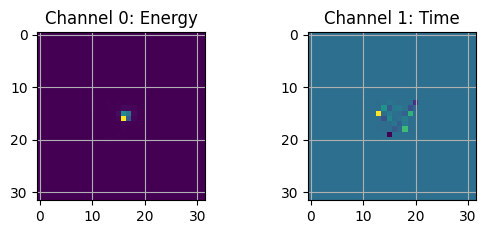

In [6]:
# plot sample of traiing images
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

In [7]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(32, 32, 2)
)
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=x)


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr_init), metrics=['accuracy'])
model.summary()

/home/choij/miniconda3/envs/kias/lib/python3.11/site-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
2023-07-05 13:11:54.491833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 13:11:54.492048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 13:11:54.492193: I tensorflow/compiler

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 2)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   6336        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
checkpoint_filepath="/checkpoints"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        "./checkpoints",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
)

history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr, checkpoint_callback],\
        verbose=1, shuffle=True)

Epoch 1/20


2023-07-05 13:12:09.193231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-07-05 13:12:10.002665: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f19106b8240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-05 13:12:10.002702: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-07-05 13:12:10.005735: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-05 13:12:10.101645: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-07-05 13:12:10.494900: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-all

3200/3200 [==============================] - 128s 33ms/step - loss: 0.6710 - accuracy: 0.5953 - val_loss: 0.6584 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 2/20
3200/3200 [==============================] - 105s 33ms/step - loss: 0.6407 - accuracy: 0.6356 - val_loss: 0.6275 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 3/20
3200/3200 [==============================] - 102s 32ms/step - loss: 0.6167 - accuracy: 0.6652 - val_loss: 0.6257 - val_accuracy: 0.6626 - lr: 0.0010
Epoch 4/20
3200/3200 [==============================] - 102s 32ms/step - loss: 0.6101 - accuracy: 0.6727 - val_loss: 0.6371 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 5/20
3200/3200 [==============================] - 103s 32ms/step - loss: 0.5913 - accuracy: 0.6921 - val_loss: 0.5901 - val_accuracy: 0.6904 - lr: 0.0010
Epoch 6/20
3200/3200 [==============================] - 103s 32ms/step - loss: 0.5829 - accuracy: 0.6987 - val_loss: 0.5912 - val_accuracy: 0.6899 - lr: 0.0010
Epoch 7/20
3200/3200 [=============================

In [9]:
# evaluate the model
model.load_weights("./checkpoints")
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./checkpoints

NameError: name 'fpr' is not defined

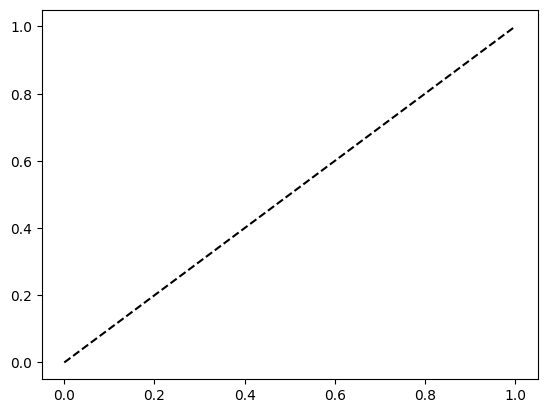

: 

In [10]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()